In [281]:
# !pip install statsmodels

  Using cached statsmodels-0.13.2-cp310-cp310-win_amd64.whl (9.1 MB)
  Using cached patsy-0.5.2-py2.py3-none-any.whl (233 kB)

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: C:\Users\IsakG\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [314]:
import pandas as pd
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.stattools import durbin_watson

from IPython.display import Latex

In [231]:
df = pd.read_csv("weatherHistory.csv")
print(df.dtypes)
df.head()

Formatted Date               object
Summary                      object
Precip Type                  object
Temperature (C)             float64
Apparent Temperature (C)    float64
Humidity                    float64
Wind Speed (km/h)           float64
Wind Bearing (degrees)      float64
Visibility (km)             float64
Loud Cover                  float64
Pressure (millibars)        float64
Daily Summary                object
dtype: object


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [232]:
df = df.loc[:,["Formatted Date", "Temperature (C)"]]
df["Formatted Date"] = pd.to_datetime(df["Formatted Date"])



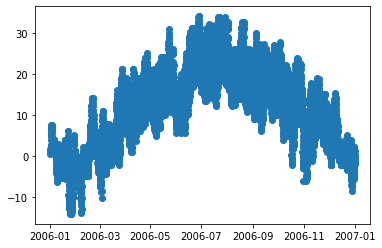

In [233]:
plt.scatter(df.loc[df["Formatted Date"].apply(lambda x: x.year) < 2007, "Formatted Date"], df.loc[df["Formatted Date"].apply(lambda x: x.year) < 2007, "Temperature (C)"])#  , linewidths=.001)

In [234]:
from datetime import datetime


def yearsSinceStartOfYear(t: datetime) -> float:
    t = t.replace(tzinfo=None)
    #print(t)
    startOfYear = datetime(year=t.year, month=1, day=1)
    
    dayDelta = (t-startOfYear).days
    
    yearDelta = dayDelta / 365.242199
    
    return(yearDelta)

def daysSinceStartOfDay(t:datetime) -> float:
    t = t.replace(tzinfo=None)
    
    dayDelta = t.hour / 24

    return(dayDelta)
    
year = df["Formatted Date"].apply(lambda x: x.year)

timeOfYear = df["Formatted Date"].apply(yearsSinceStartOfYear)
timeOfDay = df["Formatted Date"].apply(daysSinceStartOfDay)

temp = df["Temperature (C)"]

df_fit = pd.DataFrame(data=
                      dict(zip(["Year","ToY","ToD","Temp"],(year,timeOfYear,timeOfDay,temp)))
                    )

num_nan_rows = df_fit.isna().sum()
display(num_nan_rows)
df_fit = df_fit.dropna()
df_fit.head()


Year    0
ToY     0
ToD     0
Temp    0
dtype: int64

,Year,ToY,ToD,Temp
0,2006,0.246412,0.000000,9.472222
1,2006,0.246412,0.041667,9.355556
2,2006,0.246412,0.083333,9.377778
3,2006,0.246412,0.125000,8.288889
4,2006,0.246412,0.166667,8.755556


In [271]:
df_fit.ToD.max()
#23/24

0.9583333333333334

In [235]:
def mse(y_hat, y):
    res = y_hat - y
    return(np.mean(np.square(res)))


def r_2(y_hat,y):
    y_bar = np.mean(y)
    
    val = 1 - (np.sum(np.square(y_hat-y)) / np.sum(np.square(y - y_bar)))
    
    return(val)
    

In [236]:
%%latex
### my Model
$$  
Temp = \alpha_0 * Y + \alpha_1 * sin(\theta_1 * \pi * ToY + \Delta_1) + \alpha_2 * sin(\theta_2 * \pi * ToD + \Delta_2) + \epsilon
$$




<IPython.core.display.Latex object>

In [237]:
def model(params, data): 
    """_summary_

    Args:
        params (list(float)): [alpha_0, alpha_1, alpha_2, theta_1, theta_2, delta_1, delta_2]
        data (_type_): X matrix, [Year, TimeOfyear, TimeOfDay]
        
    returns 
    """
    term1 = params[0] * data[:,0] #linear: year
    
    term2 = params[1] * np.sin(params[3]*np.pi*data[:,1] + params[5])  #sigmoid: time of year
    
    term3 = params[2] * np.sin(params[4]*np.pi*data[:,2] + params[6])  #sigmoid: time of day
    
    yhat = term1 + term2 + term3
    
    
    return(np.matrix(yhat).T)



    

In [238]:
X = df_fit.drop("Temp",axis=1).values
y_true = np.matrix(df_fit.Temp.values).T


display(X.shape)
display(X)

display(y_true.shape)
display(y_true)

(96453, 3)

array([[2.00600000e+03, 2.46411834e-01, 0.00000000e+00],
       [2.00600000e+03, 2.46411834e-01, 4.16666667e-02],
       [2.00600000e+03, 2.46411834e-01, 8.33333333e-02],
       ...,
       [2.01600000e+03, 6.89953134e-01, 8.75000000e-01],
       [2.01600000e+03, 6.89953134e-01, 9.16666667e-01],
       [2.01600000e+03, 6.89953134e-01, 9.58333333e-01]])

(96453, 1)

matrix([[ 9.47222222],
        [ 9.35555556],
        [ 9.37777778],
        ...,
        [22.03888889],
        [21.52222222],
        [20.43888889]])

In [311]:

def getFunToOptimize(eval, mod, data,y_true):
    
    return(
        lambda params: eval(y_true,mod(params,data))
            )
    
fun = getFunToOptimize(mse,model,X,y_true)

params_0 = np.repeat(1,7)

res = optimize.minimize(fun,params_0,method="BFGS")
fittedParams = res.x
display(res)


      fun: 27.770759127113905
 hess_inv: array([[ 7.36251734e-07,  1.81894295e-03,  2.20269448e-04,
        -1.90901263e-04,  6.85430544e-05,  3.10976250e-04,
         4.36866029e-04],
       [ 1.81894295e-03,  1.05989295e+01,  1.21185778e+00,
        -4.99219706e-01,  6.07851298e-01,  7.45513328e-01,
         2.52306279e+00],
       [ 2.20269448e-04,  1.21185778e+00,  1.08074878e+00,
        -4.02179313e-02,  2.21809557e-01,  5.43281733e-02,
        -3.90409218e-01],
       [-1.90901263e-04, -4.99219706e-01, -4.02179313e-02,
         6.06375334e-02, -1.02425615e-02, -9.96965329e-02,
        -1.36244133e-01],
       [ 6.85430544e-05,  6.07851298e-01,  2.21809557e-01,
        -1.02425615e-02,  6.84649862e-01,  7.69272827e-03,
        -1.73450074e-01],
       [ 3.10976250e-04,  7.45513328e-01,  5.43281733e-02,
        -9.96965329e-02,  7.69272827e-03,  1.72397022e-01,
         2.09825168e-01],
       [ 4.36866029e-04,  2.52306279e+00, -3.90409218e-01,
        -1.36244133e-01, -1.73450074

In [313]:
print(fittedParams)
y_hat = model(fittedParams,X)
print(y_hat)

r2FittedParams = r_2(y_hat.ravel(),y_true.ravel())
r2FittedParams



[ 5.80679484e-03 -1.14025546e+01  5.39773835e-01 -1.94563921e+00
 -5.13773567e+00 -4.57324107e+00  4.60870906e-01]
[[ 9.58097372]
 [ 9.22752515]
 [ 8.92346064]
 ...
 [17.98344339]
 [17.93420046]
 [18.1154564 ]]


0.6955998361078912

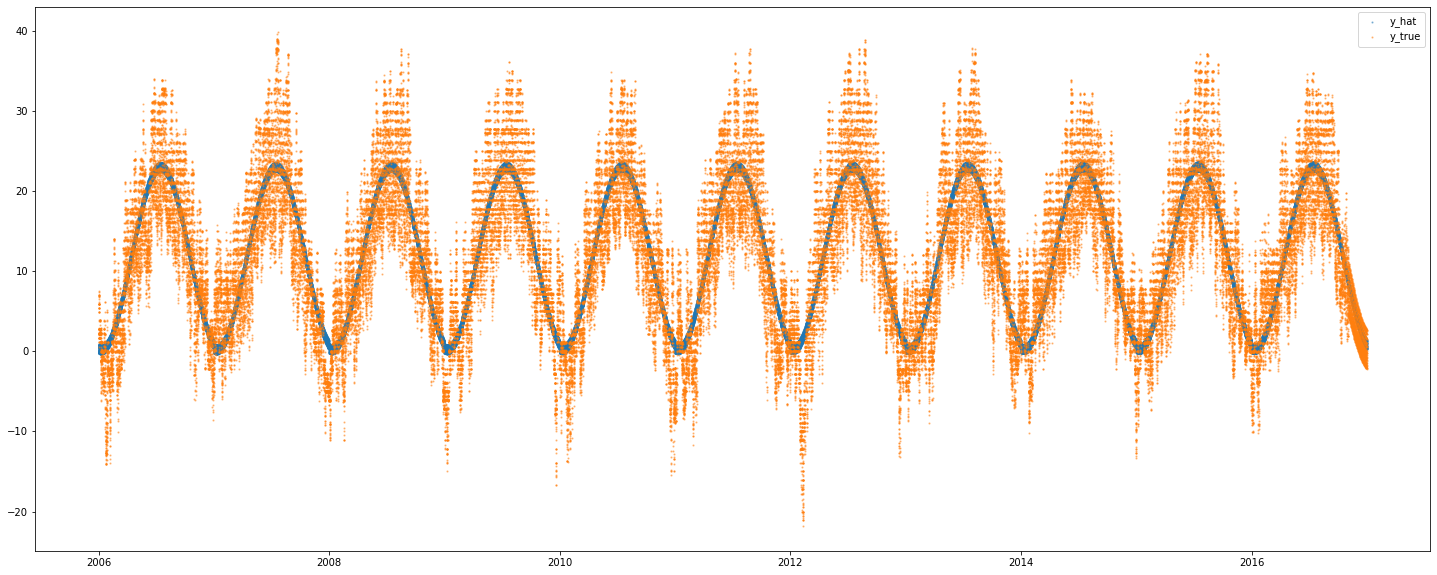

In [279]:
plot_ind = df_fit.Year >= 2000
plot_x = df_fit.loc[plot_ind,["Year","ToY"]].sum(axis=1)

plt.figure(figsize=(25,10))
plt.scatter(plot_x, y=np.squeeze(np.asarray(y_hat[plot_ind,:])),label="y_hat",s=1.5,alpha=.4)
plt.scatter(plot_x, y=np.squeeze(np.asarray(y_true[plot_ind,:])),label="y_true",s=1.5,alpha=.4)
plt.legend()

0.02266401285658445


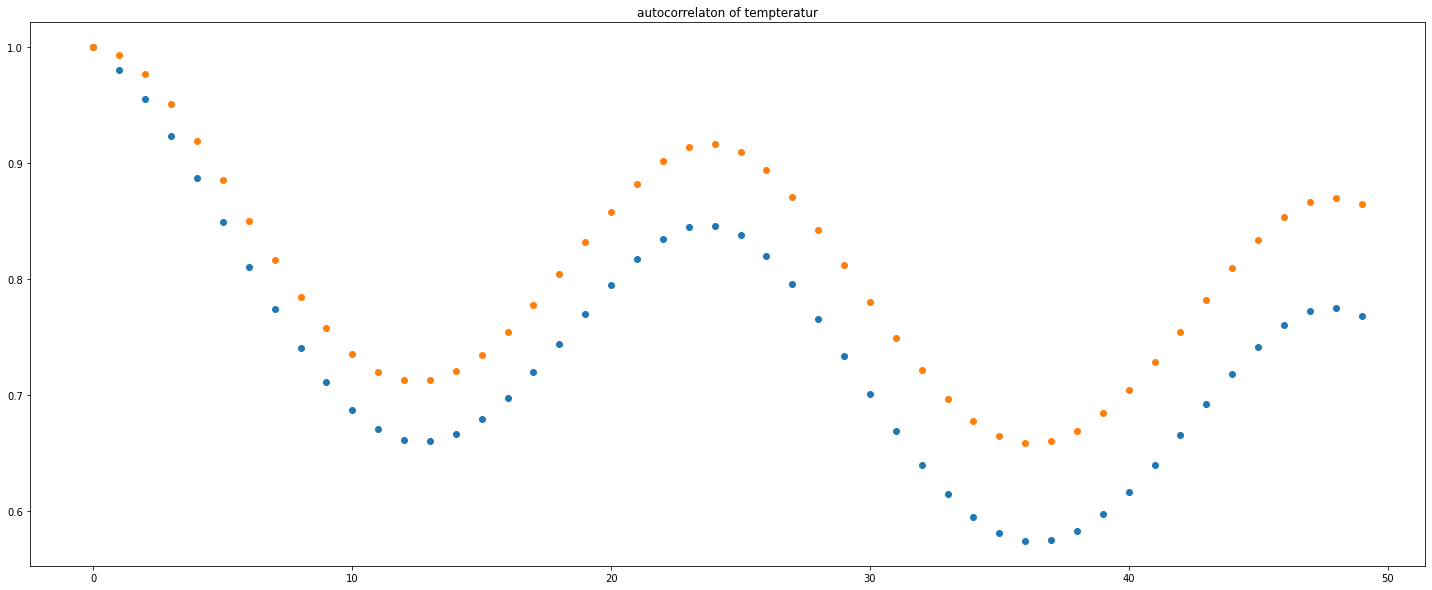

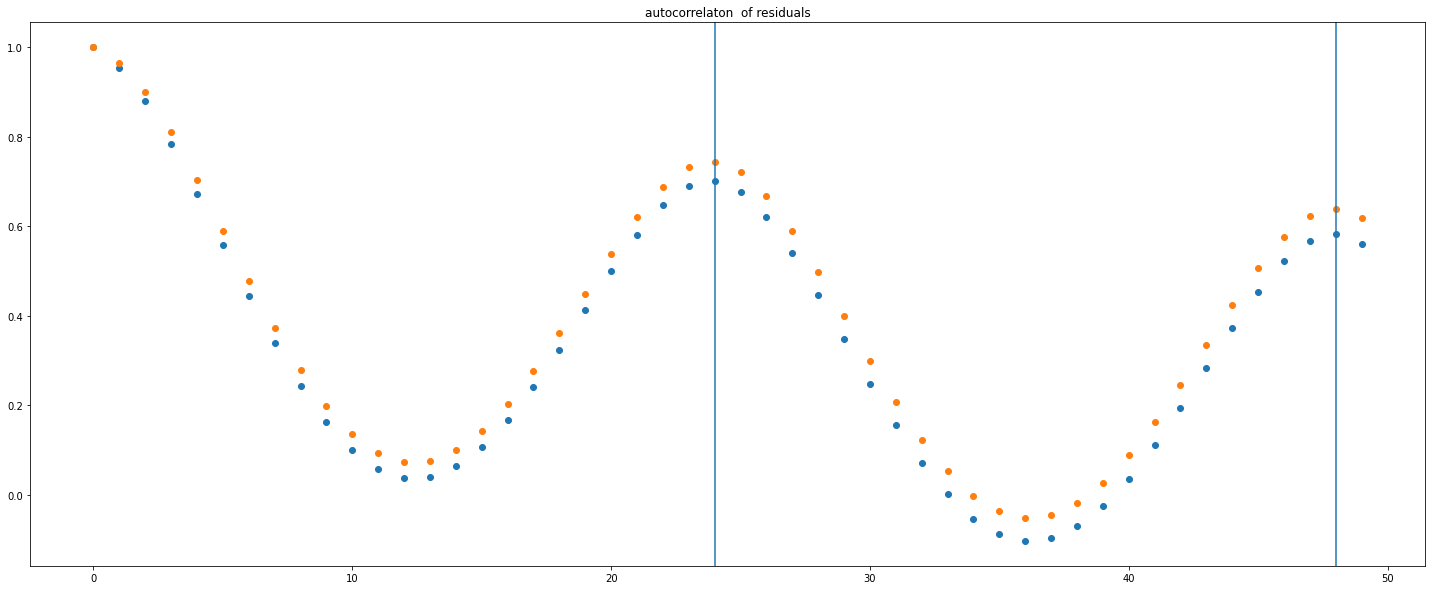

In [320]:
plt.figure(figsize=(25,10))
plt.title("autocorrelaton of tempteratur")


ac_full = acf(y_true,alpha=.05)
ac_true = ac_full[1]

plt.scatter(x=range(50),y=ac_true[:,0],label="lower" )
plt.scatter(x=range(50),y=ac_true[:,1],label="upper" )

residuals = y_hat-y_true

plt.figure(figsize=(25,10))
plt.title("autocorrelaton  of residuals")

ac_full = acf(residuals,alpha=.05)
ac_res = ac_full[1]

plt.scatter(x=range(50),y=ac_res[:,0],label="lower" )
plt.scatter(x=range(50),y=ac_res[:,1],label="upper" )
plt.axvline(x=24)
plt.axvline(x=48)
print(durbin_watson(ac_full[0]))

In [ ]:
The autocorrelation is the highest in the beginning, natrually. But aslo has peaks at 24 and 48. The period coincides with the length of day. 
It seems that the temperature exactly one or two days ago tell us more about the temperature right now, than the temperature a few hours ago.
adding autoregressive terms to our model would increase accuracy.

(array([1.        , 0.98671274, 0.96552735, 0.93687589, 0.90316508,
        0.86703634, 0.83041257, 0.79512091, 0.76255164, 0.73425259,
        0.71146925, 0.69541895, 0.68697086, 0.686492  , 0.69349719,
        0.70711443, 0.72594326, 0.74877924, 0.77427562, 0.80077604,
        0.82654879, 0.84971751, 0.86802386, 0.87924863, 0.88091175,
        0.87362334, 0.85680748, 0.83293527, 0.80419358, 0.77270497,
        0.74052001, 0.70931544, 0.68059686, 0.65577761, 0.63608599,
        0.62269003, 0.61649847, 0.61780995, 0.62622892, 0.64092453,
        0.66061536, 0.68414651, 0.71023106, 0.73734795, 0.76378132,
        0.78760748, 0.80687887, 0.81925596, 0.82251703, 0.81606773]),
 array([[1.        , 1.        ],
        [0.98040185, 0.99302362],
        [0.95469319, 0.97636151],
        [0.9230326 , 0.95071917],
        [0.88699251, 0.91933766],
        [0.84896628, 0.88510639],
        [0.81075532, 0.85006982],
        [0.77411291, 0.81612891],
        [0.74037745, 0.78472583],
        [0.7

In [303]:
ac = acf(y_true,alpha=.05)
ac[1][:,1]

array([1.        , 0.99302362, 0.97636151, 0.95071917, 0.91933766,
       0.88510639, 0.85006982, 0.81612891, 0.78472583, 0.75744769,
       0.73557229, 0.72034437, 0.7126574 , 0.71290014, 0.72060676,
       0.73492157, 0.75445756, 0.77802036, 0.80427067, 0.83155681,
       0.85814838, 0.88216674, 0.9013475 , 0.91346093, 0.91601247,
       0.90959379, 0.89361328, 0.87052706, 0.84251336, 0.81169112,
       0.78011142, 0.7494547 , 0.72123227, 0.69686451, 0.67758765,
       0.66457818, 0.65875368, 0.66042188, 0.66919612, 0.68425371,
       0.70432049, 0.72824754, 0.75475278, 0.78231864, 0.80923096,
       0.83356548, 0.85337133, 0.86630284, 0.8701287 , 0.864242  ])

In [ ]:
The model has R^2